## Importing and Cleaning

In [1]:
import pandas as pd
import re
import tensorflow as tf
from transformers import GPT2Tokenizer, TFGPT2LMHeadModel
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv('/data.csv')

# Clean jokes by removing URLs
def clean_joke(joke):
    return re.sub(r'http\S+|www\S+|https\S+', '', joke)

df['Joke'] = df['Joke'].apply(clean_joke)
jokes = df['Joke'].tolist()

## Tokenizing

In [2]:
# Load GPT-2 tokenizer and add padding token
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.pad_token = tokenizer.eos_token

# Load GPT-2 model
model = TFGPT2LMHeadModel.from_pretrained('gpt2')

# Tokenize jokes
tokenized_jokes = tokenizer(jokes, padding=True, truncation=True, return_tensors='tf', max_length=128)

input_ids = tokenized_jokes['input_ids']
attention_masks = tokenized_jokes['attention_mask']

labels = input_ids[:, 1:]
input_ids = input_ids[:, :-1]
attention_masks = attention_masks[:, :-1]

# Create a TensorFlow dataset
dataset = tf.data.Dataset.from_tensor_slices(({
    'input_ids': input_ids,
    'attention_mask': attention_masks
}, labels))

dataset = dataset.shuffle(len(jokes)).batch(8)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFGPT2LMHeadModel.

All the weights of TFGPT2LMHeadModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2LMHeadModel for predictions without further training.


## Compile and Train

Epoch 1/50
203/203 [==============================] - 42s 43ms/step - loss: 1.5571
Epoch 2/50
203/203 [==============================] - 9s 43ms/step - loss: 1.2407
Epoch 3/50
203/203 [==============================] - 9s 42ms/step - loss: 1.0957
Epoch 4/50
203/203 [==============================] - 9s 43ms/step - loss: 0.9665
Epoch 5/50
203/203 [==============================] - 9s 43ms/step - loss: 0.8414
Epoch 6/50
203/203 [==============================] - 9s 43ms/step - loss: 0.7228
Epoch 7/50
203/203 [==============================] - 9s 42ms/step - loss: 0.6155
Epoch 8/50
203/203 [==============================] - 9s 43ms/step - loss: 0.5138
Epoch 9/50
203/203 [==============================] - 9s 43ms/step - loss: 0.4336
Epoch 10/50
203/203 [==============================] - 9s 43ms/step - loss: 0.3679
Epoch 11/50
203/203 [==============================] - 9s 42ms/step - loss: 0.3131
Epoch 12/50
203/203 [==============================] - 9s 43ms/step - loss: 0.2763
Epoch 13/50


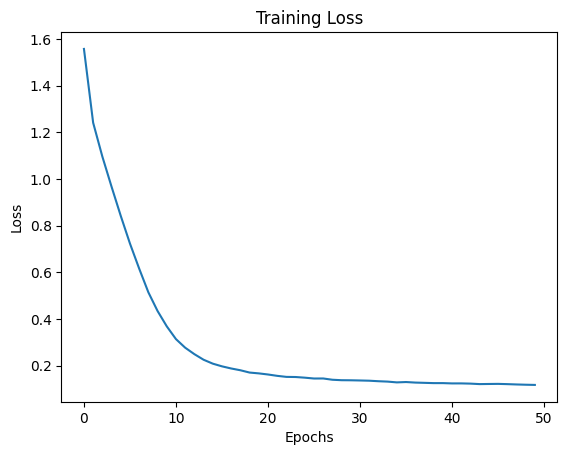

In [3]:
# Compile the model
optimizer = tf.keras.optimizers.AdamW(learning_rate=5e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer=optimizer, loss=loss)

# Train the model
history = model.fit(dataset, epochs=50)

# Plot training loss
plt.plot(history.history['loss'])
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

## Joke Generation

In [9]:
def generate_joke(start_words, max_length=50):
    # Encode the start words
    inputs = tokenizer.encode(start_words, return_tensors="tf")
    attention_mask = tf.ones_like(inputs)

    # Generate joke completion
    outputs = model.generate(
        inputs,
        attention_mask=attention_mask,
        max_length=max_length,
        num_return_sequences=1,
        no_repeat_ngram_size=2,
        do_sample=True,
        top_p=0.95,
        temperature=0.7,
        pad_token_id=tokenizer.eos_token_id
    )

    return tokenizer.decode(outputs[0], skip_special_tokens=True)

# Example usage:
start_words = [
    "What did the",
    "I like my",
    "What type of",
    "If I ever",
    "The big duck",
    "The pig flew",
    "A chicken ate"
]

for starting_word in start_words:
    joke = generate_joke(starting_word)
    print(joke)


What did the fish say when it hit the wall? Dam
I like my slaves like I like coffee Free.
What type of grain uses profanity? Vulgar Wheat
If I ever fire someone who is a Taylor Swift fan I'll say "I knew you were trouble when you clocked in."
The big duck......led a big wave. And then he said, "I'll stay here."
The pig flew into the boiling pot of water. And the bartender said, "What will you have?"
A chicken ate a chicken coup. Its owner was impeached, but the chicken didn't go to prison.


## Ablation Study

Epoch 1/50
203/203 [==============================] - 42s 42ms/step - loss: 10.8541
Epoch 2/50
203/203 [==============================] - 8s 42ms/step - loss: 3.2155
Epoch 3/50
203/203 [==============================] - 9s 42ms/step - loss: 3.0884
Epoch 4/50
203/203 [==============================] - 8s 41ms/step - loss: 2.8267
Epoch 5/50
203/203 [==============================] - 9s 42ms/step - loss: 2.6257
Epoch 6/50
203/203 [==============================] - 9s 42ms/step - loss: 2.5912
Epoch 7/50
203/203 [==============================] - 8s 42ms/step - loss: 2.5696
Epoch 8/50
203/203 [==============================] - 8s 41ms/step - loss: 2.5596
Epoch 9/50
203/203 [==============================] - 8s 42ms/step - loss: 2.6074
Epoch 10/50
203/203 [==============================] - 8s 41ms/step - loss: 2.5710
Epoch 11/50
203/203 [==============================] - 8s 41ms/step - loss: 2.6608
Epoch 12/50
203/203 [==============================] - 8s 42ms/step - loss: 2.5747
Epoch 13/50

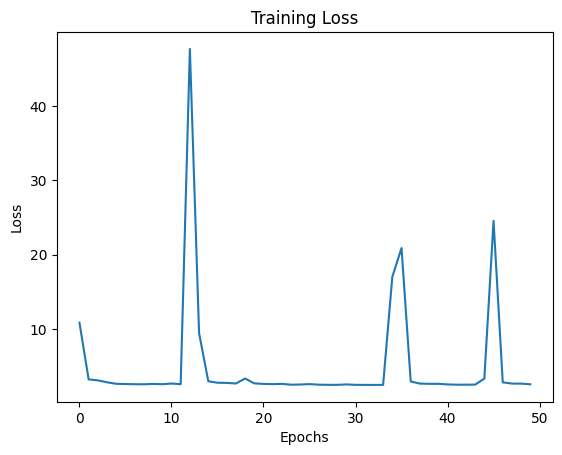

What did the did did do he you did he did? to you a you you the you with he he to Because you he a he go a a there to like was there a say to to there he when a the he the a to he
I like my go you to't to a to to you of to he a... he he say there he be Because the a he there a! he'm he to there on he...! we he: there was there the!'m to Because
What type of do did did you you did a you to say a did he you the did Because did to he a there did the he.. he he to'm there Because he of the to the one to a he, there a to to there
If I ever you you say a he he a the a there my did a to he say he go to! he to's he! to a what he you there he there. he says the he'm there! a, he me
The big duck do you did the did did you Because you to to a you a say he you the he a he say a a my a to there he there to't he he to'm a, there there a Because there Because he, Because
The pig flew did did he did to did you a did go did say did Because you you he a to a you to to you say he he you's you I: to there

In [3]:
# Compile the model
optimizer = tf.keras.optimizers.AdamW(learning_rate=5e-2)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer=optimizer, loss=loss)

# Train the model
history = model.fit(dataset, epochs=50)

# Plot training loss
plt.plot(history.history['loss'])
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

def generate_joke(start_words, max_length=50):
    # Encode the start words
    inputs = tokenizer.encode(start_words, return_tensors="tf")
    attention_mask = tf.ones_like(inputs)

    # Generate joke completion
    outputs = model.generate(
        inputs,
        attention_mask=attention_mask,
        max_length=max_length,
        num_return_sequences=1,
        no_repeat_ngram_size=2,
        do_sample=True,
        top_p=0.95,
        temperature=0.7,
        pad_token_id=tokenizer.eos_token_id
    )

    return tokenizer.decode(outputs[0], skip_special_tokens=True)

# Example usage:
start_words = [
    "What did the",
    "I like my",
    "What type of",
    "If I ever",
    "The big duck",
    "The pig flew",
    "A chicken ate"
]

for starting_word in start_words:
    joke = generate_joke(starting_word)
    print(joke)


In [4]:
model.summary()

Model: "tfgpt2lm_head_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 transformer (TFGPT2MainLay  multiple                  124439808 
 er)                                                             
                                                                 
Total params: 124439808 (474.70 MB)
Trainable params: 124439808 (474.70 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
